In [30]:
import numpy as np
import cv2
import argparse
import matplotlib.pyplot as plt
import math

In [31]:
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

In [32]:
def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()

    return kernel_2D

In [33]:
def convolution(image, kernel, average=False, verbose=False):
    if len(image.shape) == 3:
        print("Found 3 Channels : {}".format(image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        print("Image Shape : {}".format(image.shape))
 
    print("Kernel Shape : {}".format(kernel.shape))
 
    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()
 
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(image.shape)
 
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
 
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
 
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
 
    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()
 
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
 
    print("Output Image size : {}".format(output.shape))
 
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()
 
    return output

In [34]:
def gaussian_blur(image, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=math.sqrt(kernel_size), verbose=verbose)
    return convolution(image, kernel, average=True, verbose=verbose)

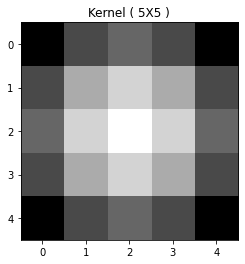

Found 3 Channels : (512, 512, 3)
Converted to Gray Channel. Size : (512, 512)
Kernel Shape : (5, 5)


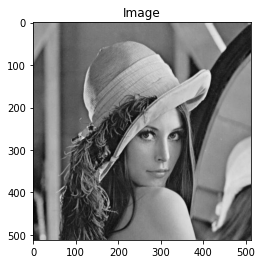

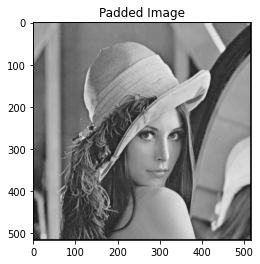

Output Image size : (512, 512)


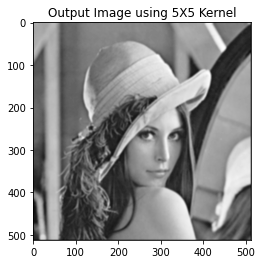

array([[ 42.86646437,  57.76070208,  68.68339329, ...,  68.49830779,
         55.80326285,  39.77003204],
       [ 58.02566729,  78.19544486,  92.97820478, ...,  92.66602051,
         75.51938457,  53.8243557 ],
       [ 69.26289053,  93.33570728, 110.98290368, ..., 110.29159049,
         89.76951815,  63.88072882],
       ...,
       [ 19.67438399,  27.36559472,  33.34341275, ...,  68.52554556,
         57.77716953,  42.84094565],
       [ 16.21449952,  22.70098015,  27.81947853, ...,  58.70691304,
         49.59923352,  36.88256898],
       [ 11.90544792,  16.76116968,  20.64295656, ...,  44.13720383,
         37.39419889,  27.90579756]])

In [43]:
  image = cv2.imread('/content/lena.jpg')
  gaussian_blur(image, 5, verbose=True)

In [44]:
def sobel_edge_detection(image, filter, convert_to_degree=False, verbose=False):
    new_image_x = convolution(image, filter, verbose)

    if verbose:
        plt.imshow(new_image_x, cmap='gray')
        plt.title("Horizontal Edge")
        plt.show()

    new_image_y = convolution(image, np.flip(filter.T, axis=0), verbose)

    if verbose:
        plt.imshow(new_image_y, cmap='gray')
        plt.title("Vertical Edge")
        plt.show()

    gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))

    gradient_magnitude *= 255.0 / gradient_magnitude.max()

    if verbose:
        plt.imshow(gradient_magnitude, cmap='gray')
        plt.title("Gradient Magnitude")
        plt.show()

    gradient_direction = np.arctan2(new_image_y, new_image_x)

    if convert_to_degree:
        gradient_direction = np.rad2deg(gradient_direction)
        gradient_direction += 180

    return gradient_magnitude, gradient_direction

Found 3 Channels : (512, 512, 3)
Converted to Gray Channel. Size : (512, 512)
Kernel Shape : (9, 9)
Output Image size : (512, 512)
Image Shape : (512, 512)
Kernel Shape : (3, 3)
Output Image size : (512, 512)


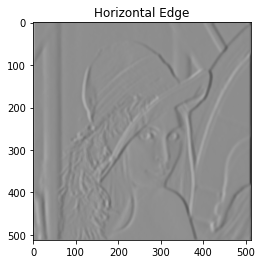

Image Shape : (512, 512)
Kernel Shape : (3, 3)
Output Image size : (512, 512)


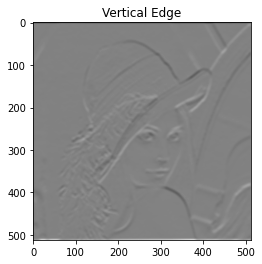

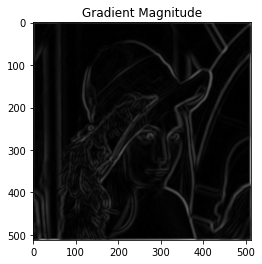

In [51]:
image = cv2.imread('lena.jpg')

blurred_image = gaussian_blur(image, kernel_size=9, verbose=False)
edge_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
gradient_magnitude, gradient_direction = sobel_edge_detection(blurred_image, edge_filter, convert_to_degree=True, verbose='verbose')


In [37]:
def non_max_suppression(gradient_magnitude, gradient_direction, verbose):
    image_row, image_col = gradient_magnitude.shape
 
    output = np.zeros(gradient_magnitude.shape)
 
    PI = 180
 
    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_direction[row, col]
 
            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]
 
            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]
 
            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]
 
            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]
 
            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col]
 
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Non Max Suppression")
        plt.show()
 
    return output

In [38]:
def threshold(image, low, high, weak, verbose=False):
    output = np.zeros(image.shape)
 
    strong = 255
 
    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image <= high) & (image >= low))
 
    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak
 
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("threshold")
        plt.show()
 
    return output

In [39]:
def hysteresis(image, weak):
    image_row, image_col = image.shape
 
    top_to_bottom = image.copy()
 
    for row in range(1, image_row):
        for col in range(1, image_col):
            if top_to_bottom[row, col] == weak:
                if top_to_bottom[row, col + 1] == 255 or top_to_bottom[row, col - 1] == 255 or top_to_bottom[row - 1, col] == 255 or top_to_bottom[
                    row + 1, col] == 255 or top_to_bottom[
                    row - 1, col - 1] == 255 or top_to_bottom[row + 1, col - 1] == 255 or top_to_bottom[row - 1, col + 1] == 255 or top_to_bottom[
                    row + 1, col + 1] == 255:
                    top_to_bottom[row, col] = 255
                else:
                    top_to_bottom[row, col] = 0
 
    bottom_to_top = image.copy()
 
    for row in range(image_row - 1, 0, -1):
        for col in range(image_col - 1, 0, -1):
            if bottom_to_top[row, col] == weak:
                if bottom_to_top[row, col + 1] == 255 or bottom_to_top[row, col - 1] == 255 or bottom_to_top[row - 1, col] == 255 or bottom_to_top[
                    row + 1, col] == 255 or bottom_to_top[
                    row - 1, col - 1] == 255 or bottom_to_top[row + 1, col - 1] == 255 or bottom_to_top[row - 1, col + 1] == 255 or bottom_to_top[
                    row + 1, col + 1] == 255:
                    bottom_to_top[row, col] = 255
                else:
                    bottom_to_top[row, col] = 0
 
    right_to_left = image.copy()
 
    for row in range(1, image_row):
        for col in range(image_col - 1, 0, -1):
            if right_to_left[row, col] == weak:
                if right_to_left[row, col + 1] == 255 or right_to_left[row, col - 1] == 255 or right_to_left[row - 1, col] == 255 or right_to_left[
                    row + 1, col] == 255 or right_to_left[
                    row - 1, col - 1] == 255 or right_to_left[row + 1, col - 1] == 255 or right_to_left[row - 1, col + 1] == 255 or right_to_left[
                    row + 1, col + 1] == 255:
                    right_to_left[row, col] = 255
                else:
                    right_to_left[row, col] = 0
 
    left_to_right = image.copy()
 
    for row in range(image_row - 1, 0, -1):
        for col in range(1, image_col):
            if left_to_right[row, col] == weak:
                if left_to_right[row, col + 1] == 255 or left_to_right[row, col - 1] == 255 or left_to_right[row - 1, col] == 255 or left_to_right[
                    row + 1, col] == 255 or left_to_right[
                    row - 1, col - 1] == 255 or left_to_right[row + 1, col - 1] == 255 or left_to_right[row - 1, col + 1] == 255 or left_to_right[
                    row + 1, col + 1] == 255:
                    left_to_right[row, col] = 255
                else:
                    left_to_right[row, col] = 0
 
    final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right
 
    final_image[final_image > 255] = 255
 
    return final_image

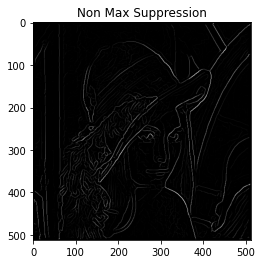

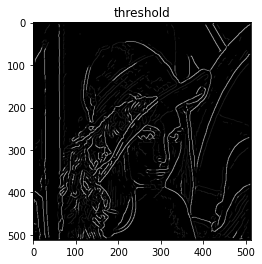

In [53]:
new_image = non_max_suppression(gradient_magnitude, gradient_direction, verbose='verbose')
weak = 50
new_image = threshold(new_image, 5, 20, weak=weak, verbose='verbose')
new_image = hysteresis(new_image, weak)